# Combining Web Scrape with Company Data

Company data was fetched via SQL and now needs to be combined with the data scraped from UN PRI to determine whether UN PRI data has predictive power over some of our fields. However, we must first handle entity concordance between the two data sets, as the naming conventions differ from UN PRI to Preqin.

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [340]:
pd.set_option('display.max_columns', 200)

In [136]:
entities = pd.read_csv('./datasets/PRI_urls.csv')

In [137]:
entities.head()

,name,id
0,123 Investment Managers (123 IM),8D30DD50-49F0-4CD1-A6B1-406A18F02F37
1,1919 Investment Counsel,6DD817D4-87D8-4110-975B-698F8DCB7792
2,1Sharpe Capital LLC,E740F8EA-BD88-4EC5-836C-50515F749B20
3,21 Invest,553A060D-E007-4ACF-A26F-77C88EDD4D26
4,27Four Investment Managers,5047A032-8A36-406C-A32C-5201E24F9FA2


In [138]:
preqin_esg = pd.read_csv('./datasets/preqin_esg.csv')

In [139]:
entityname_list = entities['name'].tolist()

Need to clean both series (lower, delete corporate suffixes) and make new series for both of identical length with clean names.

In [141]:
preqin_names = preqin_esg['Firm Name'].str.lower()
preqin_names.drop_duplicates(inplace=True)
preqin_names.str.strip()
preqin_names = preqin_names.replace(to_replace=[' llc',' ltd',' inc',' oy',',','.',' sà rl',' sarl',' nv',' pty','(pty)',' plc',' pte',' limited',' llp',' bv',' sgr',' sàrl',' spa',' avh',' lp'], value='')
preqin_names = preqin_names.replace(to_replace='-Fonden ', value='')
preqin_names.head()

0           private advisors
2            tkp investments
4    access capital partners
6      adams street partners
8             schroder adveq
Name: Firm Name, dtype: object

In [142]:
unpri_names = entities['name'].str.lower()
unpri_names = unpri_names.str.replace('&amp;','&')
unpri_names.str.strip()
unpri_names = unpri_names.replace(to_replace=[' llc',' ltd',' inc',' oy',',','.',' sà rl',' sarl',' nv',' pty','(pty)','(provisional signatory)',' plc',' pte',' limited',' llp',' bv',' sgr',' sàrl',' spa',' avh',' lp'], value='')
unpri_names = unpri_names.replace(to_replace='kohlberg kravis roberts & co', value='kkr')
unpri_names.head()

0    123 investment managers (123 im)
1             1919 investment counsel
2                 1sharpe capital llc
3                           21 invest
4          27four investment managers
Name: name, dtype: object

With clean names between the Preqin and UN PRI data sets, I must now run a distance algorithm between the strings in a resulting match_df (with duplicating entries for both unpri and preqin). The string distance function was stolen online from https://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/.

In [144]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "{}".format(distance[row][col])

In [145]:
levenshtein_ratio_and_distance('word', 'wordy', ratio_calc = True)

0.8888888888888888

In [146]:
levenshtein_ratio_and_distance('wordiiiiiiiiii', 'wordyiiiiiiiiiii', ratio_calc = True)

0.9333333333333333

#### CAUTION: This loop takes ~14 hours to run!!!

The following function runs the distance from every Preqin name for every single UN PRI name in the function. 

In [147]:
new_list = []
for i in preqin_names:
    for j in unpri_names:
        new_list.append([i,j,levenshtein_ratio_and_distance(i,j,ratio_calc = True)])

In [148]:
new_list

[['private advisors', '123 investment managers (123 im)', 0.3333333333333333],
 ['private advisors', '1919 investment counsel', 0.358974358974359],
 ['private advisors', '1sharpe capital llc', 0.2857142857142857],
 ['private advisors', '21 invest', 0.32],
 ['private advisors', '27four investment managers', 0.42857142857142855],
 ['private advisors', '3i group plc', 0.21428571428571427],
 ['private advisors', '747 capital', 0.2962962962962963],
 ['private advisors', '8 miles', 0.2608695652173913],
 ['private advisors', 'a plus finance sas', 0.4117647058823529],
 ['private advisors', 'aac capital benelux', 0.22857142857142856],
 ['private advisors', 'aag investment management pty ltd', 0.2857142857142857],
 ['private advisors', 'ab invalda invl', 0.3225806451612903],
 ['private advisors', 'ab max sievert', 0.3333333333333333],
 ['private advisors', 'abac solutions manager s.à r.l.', 0.2553191489361702],
 ['private advisors', 'abbott capital', 0.3333333333333333],
 ['private advisors', 'a

Convert resulting list to df

In [433]:
new_df = pd.DataFrame(new_list,columns=['preqin','unpri','score'])
new_df.sort_values(by="score", ascending=False).head()

,preqin,unpri,score
1835032,appian holdings,appian holdings,1.0
4043750,amundi,amundi,1.0
3098083,hudson clean energy partners,hudson clean energy partners,1.0
5392753,adamantem capital,adamantem capital,1.0
5086431,great lakes advisors,great lakes advisors,1.0


Need one best score per Preqin entity, rather than all the scores of all Preqin entities, so I group by score and only present max.

In [434]:
idx = new_df.groupby(['preqin'])['score'].transform(max) == new_df['score']
matched_df = new_df[idx]

In [435]:
matched_df.loc[matched_df['score'] > 0.93].sort_values('score',ascending=True).head()

,preqin,unpri,score
423508,kbc asset management,kbc asset management nv,0.930233
4992315,delcap asset management,ecp asset management,0.930233
3644855,causeway capital management,causeway capital management llc,0.931034
3000248,deerpath capital management,"deerpath capital management, lp",0.931034
3604428,securis investment partners,securis investment partners llp,0.931034


UN PRI names did not get rid of LLP, BV, LLC, etc. I don't know why... Regardless, a score of 0.93 or better seems to have a decent tradeoff between accuracy and false positives. I could create better matching model with identifying factors but only identifying factors that look interesting for potential overlap in UN PRI are AUM on first page--this is clarified in Phase 2 wish list below.

In [436]:
matched_df['unpri match'] = np.where(matched_df['score']>=0.93, matched_df['unpri'], None)
matched_df.head()

C:\Users\michael.amenta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,preqin,unpri,score,unpri match
1331,private advisors,"private advisors, llc",0.864865,None
3107,tkp investments,pggm investments,0.838710,None
3639,access capital partners,access capital partners,1.000000,access capital partners
5456,adams street partners,adams street partners llc,0.913043,None
8673,schroder adveq,schroders,0.695652,None


Next few lines of code attempt to organize the dataframe to include score, and both clean and original entity names for both UN PRI and Preqin so that we can merge the data sets.

In [437]:
combined_df = matched_df.drop('unpri',axis=1)

In [479]:
#combine cleaned Preqin name with original Preqin name
preqin_matches = pd.DataFrame(preqin_esg['Firm Name'])
preqin_matches['preqin_clean'] = preqin_names

preqin_matches.head()

,Firm Name,preqin_clean
0,Private Advisors,private advisors
2,TKP Investments,tkp investments
4,Access Capital Partners,access capital partners
6,Adams Street Partners,adams street partners
8,Schroder Adveq,schroder adveq


Merging data is useful for disparate data sets (out of order) but that have a common set of columns--similar to joining in SQL. 

In [439]:
combined_df = pd.merge(left=combined_df,right=preqin_matches,on=None,left_on='preqin',right_on='preqin_clean')
combined_df.tail()

,preqin,score,unpri match,Firm Name,preqin_clean
3859,l&r capital,0.818182,None,L&R Capital,l&r capital
3860,institutional investment partners denmark,0.705882,None,Institutional Investment Partners Denmark,institutional investment partners denmark
3861,yellowdog,0.413793,None,Yellowdog,yellowdog
3862,noles properties,0.592593,None,Noles Properties,noles properties
3863,agbe capital,0.846154,None,AGBE Capital,agbe capital


In [441]:
combined_df.to_csv(r'C:\Users\michael.amenta\DAT_MA\datasets\entity_concord.csv')

In [442]:
#import preqin_names as new col to combined_df 
combined_df.rename(columns = {'Firm Name':'Preqin Official'}, inplace = True)
combined_df.tail()

,preqin,score,unpri match,Preqin Official,preqin_clean
3859,l&r capital,0.818182,None,L&R Capital,l&r capital
3860,institutional investment partners denmark,0.705882,None,Institutional Investment Partners Denmark,institutional investment partners denmark
3861,yellowdog,0.413793,None,Yellowdog,yellowdog
3862,noles properties,0.592593,None,Noles Properties,noles properties
3863,agbe capital,0.846154,None,AGBE Capital,agbe capital


In [478]:
#combine cleaned name with original name for unpri
entities['unpri_clean'] = unpri_names
unpri_merge = entities.drop('id',axis=1)
unpri_merge.tail()

,name,unpri_clean
1801,Ysios Capital,ysios capital
1802,Zadig,zadig
1803,Zouk Capital,zouk capital
1804,Zürcher Kantonalbank,zürcher kantonalbank
1805,Zurich Insurance Group,zurich insurance group


In [444]:
combined_df = pd.merge(combined_df,unpri_merge,how='inner',left_on = 'unpri match', right_on = 'unpri_clean')
combined_df.sort_values('score',ascending=True).head()

,preqin,score,unpri match,Preqin Official,preqin_clean,name,unpri_clean
486,delcap asset management,0.930233,ecp asset management,Delcap Asset Management,delcap asset management,ECP Asset Management,ecp asset management
37,kbc asset management,0.930233,kbc asset management nv,KBC Asset Management,kbc asset management,KBC Asset Management NV,kbc asset management nv
394,causeway capital management,0.931034,causeway capital management llc,Causeway Capital Management,causeway capital management,Causeway Capital Management LLC,causeway capital management llc
392,securis investment partners,0.931034,securis investment partners llp,Securis Investment Partners,securis investment partners,Securis Investment Partners LLP,securis investment partners llp
318,deerpath capital management,0.931034,"deerpath capital management, lp",Deerpath Capital Management,deerpath capital management,"Deerpath Capital Management, LP","deerpath capital management, lp"


In [445]:
combined_df = combined_df.rename(columns = {'name':'UN PRI Official'})
combined_df.head()

,preqin,score,unpri match,Preqin Official,preqin_clean,UN PRI Official,unpri_clean
0,access capital partners,1.0,access capital partners,Access Capital Partners,access capital partners,Access Capital Partners,access capital partners
1,pinebridge investments,1.0,pinebridge investments,PineBridge Investments,pinebridge investments,PineBridge Investments,pinebridge investments
2,ardian,1.0,ardian,Ardian,ardian,Ardian,ardian
3,coller capital,1.0,coller capital,Coller Capital,coller capital,Coller Capital,coller capital
4,gcm grosvenor,1.0,gcm grosvenor,GCM Grosvenor,gcm grosvenor,GCM Grosvenor,gcm grosvenor


In [447]:
combined_df = combined_df.drop('preqin',axis=1)
combined_df.head()

,score,unpri match,Preqin Official,preqin_clean,UN PRI Official,unpri_clean
0,1.0,access capital partners,Access Capital Partners,access capital partners,Access Capital Partners,access capital partners
1,1.0,pinebridge investments,PineBridge Investments,pinebridge investments,PineBridge Investments,pinebridge investments
2,1.0,ardian,Ardian,ardian,Ardian,ardian
3,1.0,coller capital,Coller Capital,coller capital,Coller Capital,coller capital
4,1.0,gcm grosvenor,GCM Grosvenor,gcm grosvenor,GCM Grosvenor,gcm grosvenor


In [448]:
combined_df = combined_df.drop('unpri match',axis=1)
combined_df.head()

,score,Preqin Official,preqin_clean,UN PRI Official,unpri_clean
0,1.0,Access Capital Partners,access capital partners,Access Capital Partners,access capital partners
1,1.0,PineBridge Investments,pinebridge investments,PineBridge Investments,pinebridge investments
2,1.0,Ardian,ardian,Ardian,ardian
3,1.0,Coller Capital,coller capital,Coller Capital,coller capital
4,1.0,GCM Grosvenor,gcm grosvenor,GCM Grosvenor,gcm grosvenor


Columns are now all present, just want to resort for clarity

In [449]:
combined_df = combined_df[['Preqin Official','preqin_clean', 'UN PRI Official', 'unpri_clean', 'score']]
combined_df.sort_values('score',ascending=True).head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score
486,Delcap Asset Management,delcap asset management,ECP Asset Management,ecp asset management,0.930233
37,KBC Asset Management,kbc asset management,KBC Asset Management NV,kbc asset management nv,0.930233
394,Causeway Capital Management,causeway capital management,Causeway Capital Management LLC,causeway capital management llc,0.931034
392,Securis Investment Partners,securis investment partners,Securis Investment Partners LLP,securis investment partners llp,0.931034
318,Deerpath Capital Management,deerpath capital management,"Deerpath Capital Management, LP","deerpath capital management, lp",0.931034


Now its time to import the data sets and combine them all into one dataframe

In [451]:
#import preqin data 
unpri_data = pd.read_csv('./datasets/survey_test3.csv')
unpri_data.head()

,Unnamed: 0,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association,Australian Council of Superannuation Investors,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure of responsible investment practices across the investment indust

In [452]:
combined_df = pd.merge(combined_df,unpri_data,how='inner',left_on = 'UN PRI Official', right_on = 'Unnamed: 0')
combined_df.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Unnamed: 0,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association,Australian Council of Superannuation Investors,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure o

In [453]:
combined_df = combined_df.drop('Unnamed: 0',axis=1)
combined_df.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association,Australian Council of Superannuation Investors,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure of responsib

In [454]:
preqin_data = pd.read_csv('./datasets/preqin_esg.csv')
preqin_data.head()

,Firm ID,Firm Name,GP or LP,Firm Type,Firm Country,Firm Region,ESG Status,ESG Policy Date Established,Impact Investing,ESG Status Date Established,General Policy Applied to Asset Classes,Asset class specific Policy,Asset class specific Policy 2,Asset class specific Policy 3,Socially Responsible Investment,ESG Policy URL,Additional Information,Active On Pro,Internal note date,Internal note update type,Internal note note type,Asia Investor Group on Climate Change,Asian Corporate Governance Association,Australian Council of Superannuation Investors,Carbon Disclosure Project (Formerly),Ceres,Climate Action 100+,Council of Institutional Investors,ESG Research Austrailia,Eumedion,Eurosif,FAIRR,Global Impact Investing Network,Global Real Estate Sustainability Benchmark – Infrastructure,Global Real Estate Sustainability Benchmark – Real Estate,IFC Operating Principles for Impact Management,Institutional Investors Group on Climate Change,Interfaith Center on Corporate Responsibility,International Corporate Governance Network,Invest Europe Responsible Investment Roundtable,Investor Group on Climate Change,Local Authority Pension Fund Forum,Principles for Responsible Investment (PRI),Responsible Investment Association (RIA),Responsible Investment Association Australia,Sustainability Accounting Standards Board,Task Force on Climate-related Financial Disclosures,UK Sustainable Investment and Finance Association,United Nations Environment Programme Finance Initiative,United Nations Global Compact,US SIF,ESG Sub Policies Type,ESG Sub Policies Date,ESG Sub Policies Policy Link,Sub Policy 2,Sub Policy 3,Dupes?
0,12358,Private Advisors,LP,Fund of Hedge Funds Manager,US,North America,Yes,NaN,Unknown,NaN,HF,PE,NaN,NaN,NaN,NaN,Private Advisors has shown a commitment to ESG...,HF,43697.0,Partial Update,Web Research,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,12358,Private Advisors,GP,Fund of Hedge Funds Manager,US,North America,Yes,NaN,Unknown,NaN,HF,NaN,NaN,NaN,No,https://www.cliens.se/ansvarsfulla-investeringar,NaN,HF,43766.0,Full Update,Email Communication,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,15081,TKP Investments,LP,Fund of Hedge Funds Manager,Netherlands,West Europe,Pending,38718.0,No,NaN,HF,RE,NaN,NaN,NaN,https://tkpinvestments.com/wp-content/uploads/...,TKP Investments incorporates ESG via its paren...,HF,43693.0,Partial Update,Web Research,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,15081,TKP Investments,GP,Fund of Hedge Funds Manager,Netherlands,West Europe,Pending,38718.0,No,NaN,HF,NaN,NaN,NaN,NaN,NaN,NaN,"PE,VC,HF",NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,15,Access Capital Partners,LP,Private Equity Fund of Funds Manager,France,West Europe,Yes,39083.0,No,43466.0,"PE, INF, PD, VC",NaN,NaN,NaN,Yes,https://www.access-capital-partners.com/upload...,Access Capital Partners started its engagement...,"PE, INF, PD, NR, VC",43693.0,Partial Update,Web Research,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [455]:
combined_df = pd.merge(combined_df,preqin_data,how='inner',left_on = 'Preqin Official', right_on = 'Firm Name')
combined_df.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

In [456]:
combined_df = combined_df.drop('Firm Name',axis=1)
combined_df.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

In [480]:
# combined_df.to_csv(r'C:\Users\michael.amenta\DAT_MA\datasets\preqin_unpri.csv')

With combined df, now want to focus only on Investment Managers (GPs), not Investors (LPs)

In [459]:
gp_score = combined_df.loc[combined_df['GP or LP'] == 'GP']
gp_score.shape

(562, 184)

In [460]:
gp_score.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

Want new column for count of ESG Affiliations since I don't know whether one is superior to another.

In [461]:
gp_score['affiliation_count'] = gp_score[['Asia Investor Group on Climate Change',	'Asian Corporate Governance Association_y',	'Australian Council of Superannuation Investors_y',	'Carbon Disclosure Project (Formerly)',	'Ceres',	'Climate Action 100+',	'Council of Institutional Investors',	'ESG Research Austrailia',	'Eumedion_y',	'Eurosif',	'FAIRR',	'Global Impact Investing Network',	'Global Real Estate Sustainability Benchmark – Infrastructure',	'Global Real Estate Sustainability Benchmark – Real Estate',	'IFC Operating Principles for Impact Management',	'Institutional Investors Group on Climate Change',	'Interfaith Center on Corporate Responsibility',	'International Corporate Governance Network',	'Invest Europe Responsible Investment Roundtable_y',	'Investor Group on Climate Change',	'Local Authority Pension Fund Forum_y',	'Principles for Responsible Investment (PRI)',	'Responsible Investment Association (RIA)',	'Responsible Investment Association Australia',	'Sustainability Accounting Standards Board',	'Task Force on Climate-related Financial Disclosures',	'UK Sustainable Investment and Finance Association',	'United Nations Environment Programme Finance Initiative',	'United Nations Global Compact_y',	'US SIF',
]].sum(axis=1)
gp_score.head()

C:\Users\michael.amenta\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

In [482]:
#Examine potential y columns
gp_score[['Preqin Official','IFC Operating Principles for Impact Management','Global Impact Investing Network (GIIN)']].loc[combined_df['IFC Operating Principles for Impact Management'] == 1]

,Preqin Official,IFC Operating Principles for Impact Management,Global Impact Investing Network (GIIN)
76,Rock Creek Group,1,0.0
84,BNP Paribas Asset Management,1,0.0
128,Sarona Asset Management,1,1.0
170,Community Investment Management,1,0.0
235,Norfund,1,0.0
292,Actis,1,0.0
329,UBS Asset Management,1,1.0
438,BlueOrchard Finance,1,1.0
458,LeapFrog Investments,1,1.0
560,Amundi,1,0.0


In [483]:
#Make similar count column in UN PRI for number of ESG policies
gp_score['policy_coverage'] = gp_score[[
"Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments",	'Your investment objectives that take ESG factors/real economy influence into account',	'Time horizon of your investment',	'Governance structure of organisational ESG responsibilities',	'ESG incorporation approaches',	'Active ownership approaches','Reporting','Climate change','Understanding and incorporating client / beneficiary sustainability preferences'
]].sum(axis=1)
gp_score.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

In [484]:
#Clean sub-policy column to change it from hyperlink to binary variable
gp_score['ESG Sub Policies Policy'] = gp_score['ESG Sub Policies Policy Link'].apply(lambda x: float(1) if x != 0 else float(0))
gp_score.head()

,Preqin Official,preqin_clean,UN PRI Official,unpri_clean,score,Policy setting out your overall approach,Formalised guidelines on environmental factors,Formalised guidelines on social factors,Formalised guidelines on corporate governance factors,Fiduciary (or equivalent) duties,Asset class-specific RI guidelines,Sector specific RI guidelines,Screening / exclusions policy,"Other, specify (1)","Other, specify(2)",Applicable policies cover all AUM,Applicable policies cover a majority of AUM,Applicable policies cover a minority of AUM,Your organisation’s definition of ESG and/or responsible investment and it’s relation to investments,Your investment objectives that take ESG factors/real economy influence into account,Time horizon of your investment,Governance structure of organisational ESG responsibilities,ESG incorporation approaches,Active ownership approaches,Reporting,Climate change,Understanding and incorporating client / beneficiary sustainability preferences,"Other RI considerations, specify (1)","Other RI considerations, specify (2)",No,I confirm I have read and understood the Accountability tab for SG 01,URL,Attachment (will be made public),We do not publicly disclose our investment policy documents,Attachment,We do not publicly disclose any investment policy components,Board members or trustees,Oversight/accountability for responsible investment,Implementation of responsible investment,No oversight/accountability or implementation responsibility for responsible investment,Internal Roles (triggers other options),"Chief Executive Officer (CEO), Chief Investment Officer (CIO), Chief Operating Officer (COO), Investment Committee","Other Chief-level staff or head of department, specify",Portfolio managers,Investment analysts,Dedicated responsible investment staff,Investor relations,"Other role, specify (1)","Other role, specify (2)",External managers or service providers,I confirm I have read and understood the Accountability tab for SG 07,Principles for Responsible Investment,Basic Moderate Advanced,Asian Corporate Governance Association_x,Australian Council of Superannuation Investors_x,AFIC – La Commission ESG,BVCA – Responsible Investment Advisory Board,CDP Climate Change,CDP Forests,CDP Water,CFA Institute Centre for Financial Market Integrity,Code for Responsible Investment in SA (CRISA),Code for Responsible Finance in the 21st Century,Council of Institutional Investors (CII),Eumedion_x,Extractive Industries Transparency Initiative (EITI),ESG Research Australia,Invest Europe Responsible Investment Roundtable_x,Global Investors Governance Network (GIGN),Global Impact Investing Network (GIIN),Global Real Estate Sustainability Benchmark (GRESB),Green Bond Principles,Institutional Investors Group on Climate Change (IIGCC),Interfaith Center on Corporate Responsibility (ICCR),International Corporate Governance Network (ICGN),"Investor Group on Climate Change, Australia/New Zealand (IGCC)",International Integrated Reporting Council (IIRC),Investor Network on Climate Risk (INCR)/CERES,Local Authority Pension Fund Forum_x,Principles for Sustainable Insurance,"Regional or National Social Investment Forums (e.g. UKSIF, Eurosif, ASRIA, RIAA), specify",Responsible Finance Principles in Inclusive Finance,Shareholder Association for Research and Education (Share),United Nations Environmental Program Finance Initiative (UNEP FI),United Nations Global Compact_x,"Other collaborative organisation/initiative, specify","Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",Quarterly or more frequently,Biannually,Annually,Less frequently than annually,Ad hoc,Other,Provided financial support for academic or industry research on responsible investment,Provided input and/or collaborated with academia on RI related work,Encouraged better transparency and disclosure 

In [485]:
#fill na's with 0's
gp_score = gp_score.fillna(0)

In [466]:
y = gp_score['IFC Operating Principles for Impact Management']
#Or 'Global Impact Investing Network (GIIN)'

Determine remaining feature columns using subjective knowledge of ESG

In [467]:
feature_cols = ['ESG Sub Policies Policy','affiliation_count','Policy setting out your overall approach','Applicable policies cover a minority of AUM','policy_coverage','No','We do not publicly disclose our investment policy documents','We do not publicly disclose any investment policy components','No oversight/accountability or implementation responsibility for responsible investment','Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)','We do not disclose to either clients/beneficiaries or the public.','None of the above',"We did not assure last year's PRI Transparency report",'We adhere to an RI certification or labelling scheme','CEO or other Chief-Level staff']
#Preqin 1: ESG Sub Policies Policy Link needs to be made binary
#Preqin 2: count of affiliations
#UN PRI 1 (SG 01-04): Policy setting out your overall approach - must have a policy, detail level sub elements could potentially be counted but none stands out on its own
#UN PRI 2 (SG 01-04): Applicable policies cover a minority of AUM - an obvious negative factor to apply previous factor
#UN PRI 3 (SG 01-04): No - a negative factor; if they don't clarify exceptions to their policy, then maybe it's too generic
#UN PRI 4 (SG 01-04): We do not publicly disclose our investment policy documents - Another negative factor; we do want to penalize firms that aren't being transparent
#UN PRI 5 (SG 01-04): We do not publicly disclose any investment policy components - as above
#UN PRI 6 (SG 07-08): No oversight/accountability or implementation responsibility for responsible investment - refers to board level; two affirmative choices one negative, use negative as factor
#UN PRI 7 (SG 07-08): Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.) - most general promotion stat
#UN PRI 8 (SG 19): We do not disclose to either clients/beneficiaries or the public. - one negative factor more meaningful with multiple positive ones for asset class specific disclosures.
#UN PRI 9 (CM1 01): None of the above - one negative factor more meaningful with multiple positive ones for verification of compliance.
#UN PRI 9 (CM1 01): We did not assure last year's PRI Transparency report - as above for last year's assurance
#UN PRI 9 (CM1 01): We adhere to an RI certification or labelling scheme - good factor for impact assurance
#UN PRI 9 (CM1 01): CEO or other Chief-Level staff - who signs off on adherence (board and investment committee recieved low response rate)
X = gp_score[feature_cols]

In [468]:
X.describe()

,ESG Sub Policies Policy,affiliation_count,Policy setting out your overall approach,Applicable policies cover a minority of AUM,policy_coverage,No,We do not publicly disclose our investment policy documents,We do not publicly disclose any investment policy components,No oversight/accountability or implementation responsibility for responsible investment,"Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)",We do not disclose to either clients/beneficiaries or the public.,None of the above,We did not assure last year's PRI Transparency report,We adhere to an RI certification or labelling scheme,CEO or other Chief-Level staff
count,562.0,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000,562.000000
mean,1.0,1.234875,0.718861,0.014235,3.245552,0.336299,0.218861,0.231317,0.115658,0.501779,0.151246,0.677936,0.843416,0.128114,0.564057
std,0.0,0.779639,0.449956,0.118563,2.898802,0.472863,0.413843,0.422050,0.320100,0.500442,0.358607,0.467684,0.363732,0.334514,0.496321
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.0,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.0,1.000000,1.000000,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.0,9.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [486]:
#Baseline prediction
y.sum() / y.count()

0.019572953736654804

## Model Selection

Our interest is not in applying an impact label on companies, but in finding firms that are impact-like. Users will reject an impact label that's not official, but they will accept a manager scorecard that points to good qualities that lie beneath the surface. Therefore, we're looking for a supervised model.

For supervised models, the scikit-learn algorithm cheat sheet points to knn due to smaller size of data and non-textual observations. This model may be a good choice because scale of features is not an issue with small counts and dummy variables prevailing, and because I have applied business logic to ensure all features are relevant. 

For feature reduction, Ridge is preferred because the features are likely to have high degree of multicollinerity. and also feature selection models.

In [470]:
from sklearn import datasets, neighbors, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [471]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

In [472]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [473]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

0.9716312056737588


Decision trees may also be interesting for high interpretability (rather than random forests).

In [474]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [475]:
treereg = DecisionTreeClassifier(max_depth=3, random_state=1)
treereg.fit(X, y)
scores = cross_val_score(treereg, X, y, cv=5)
scores

array([0.92105263, 0.98214286, 0.98214286, 0.98214286, 0.98214286])

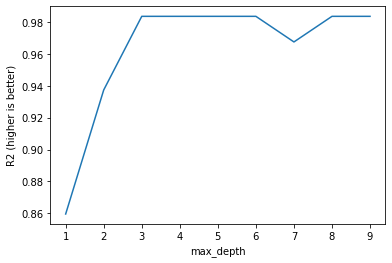

In [476]:
# List of values to try:
max_depth_range = list(range(1, 10))

# List to store the average RMSE for each value of max_depth:
R2_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    R2_scores = cross_val_score(treereg, X, y, cv=9)

# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, R2_scores);
plt.xlabel('max_depth');
plt.ylabel('R2 (higher is better)');

In [487]:
from sklearn.linear_model import Ridge
# Instantiate the model.
#(Alpha of zero has no regularization strength, essentially a basic linear regression.)
ridgereg = Ridge(alpha=0, normalize=True)
# Fit the model.
ridgereg.fit(X_train, y_train)
# Predict with fitted model.
y_pred = ridgereg.predict(X_test)
# Coefficients for a non-regularized linear regression
list(zip(feature_cols, ridgereg.coef_))

[('ESG Sub Policies Policy', 0.0),
 ('affiliation_count', 0.03789159051808768),
 ('Policy setting out your overall approach', 0.014567353935452327),
 ('Applicable policies cover a minority of AUM', 0.01150465043567917),
 ('policy_coverage', -0.003497514560715589),
 ('No', -0.022429000872096698),
 ('We do not publicly disclose our investment policy documents',
  -0.011179851492399587),
 ('We do not publicly disclose any investment policy components',
  0.017605535241809554),
 ('No oversight/accountability or implementation responsibility for responsible investment',
  0.0010673435343169142),
 ('Provided or supported education or training programmes (this includes peer to peer RI support) Your education or training may be for clients, investment managers, actuaries, broker/dealers, investment consultants, legal advisers etc.)',
  0.027058343630882508),
 ('We do not disclose to either clients/beneficiaries or the public.',
  -0.018412812455566245),
 ('None of the above', 0.009808785186946

### Phase 2: Solve for Large vs. Small Company Bias & Improving Matching Model

#### Improve Matching Model
1. Add 'Basic Information' page (79894dbc337a40828d895f9402aa63de) to webscrape to capture AUM and Assets in USD fields
2. Add AUM data to the Preqin download
3. Include these two columns as additional factors in a classification model using both name distance and AUM (rather than just name distance)

#### Solve for Large v Small Company Bias
1. Keep AUM information as a feature and do ESA to find correlations/visualizations on relationship between AUM and Y
2. Split universe into n groups and make n different models for each size group. Or add some size neutralizer factor as part of feature engineering process.

#### Miscellaneous Fixes
1. Frequency of setting RI goals and objectives: d0cc681dfa4d45dca3d70f04bc27d284 and swap it with b874458d0ecd4101869208a1fc7bab12, which has no useful information
2. Are features dropped because they have exactly the same column name? It seems that way in b8be094467a0406ead601634b02a60c6, b2a82182cc14473b90b72f6bb504fae0, and 8f2ede8902574ce5afc919af9e05c4e0--no duplicate columns exist in my csv. If not, how do you distinguish column selection of identical column names? If so, need to rescrape with new names and make features for 'no oversight/accountability...' for each of the roles below board level.
3. Dropdowns weren't considered on 57749b1a39a14fe6942aabb90698b3c1. Choice of Basic, Moderate, or Advanced all returned '1'.
